importing the required libraries

In [136]:
from collections import Counter, OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision import models 
from torch.nn.functional import softmax
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from tqdm.notebook import tqdm
import os, shutil, random

In [9]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    while isinstance(dataset, torch.utils.data.Subset):
        dataset = dataset.dataset
    class_to_index = dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

converting all images to rgb format

In [10]:
class ToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

a basic Compose of transforms to apply on images

In [11]:
from PIL import Image
import numpy as np

x = Image.open('../data/train/angry/frame_2.jpg')
np.array(x).shape

(480, 640, 3)

In [12]:
transform = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize((224, 224)),
    ToRGB(),
    transforms.ToTensor()
])

In [13]:
# paths to the data directories
data_dir = Path('..', 'data')
collected_dir = data_dir / 'collected'
train_dir = data_dir / 'train'
test_dir = data_dir / 'val'

train_dir.mkdir(exist_ok=True)
test_dir.mkdir(exist_ok=True)

In [14]:
emotions_paths = list(collected_dir.iterdir())
for path in emotions_paths:
    files = list(path.iterdir())
    split = int(0.8 * len(files))
    random.shuffle(files)
    training = files[:split]
    testing = files[split:]

    (train_dir / path.name).mkdir(parents=True, exist_ok=True)
    (test_dir / path.name).mkdir(parents=True, exist_ok=True)

    for train_file in training:
        old_dir = path / train_file.name
        new_dir = train_dir / path.name / train_file.name
        shutil.move(old_dir, new_dir)

    for test_file in testing:
        old_dir = path / test_file.name
        new_dir = test_dir / path.name / test_file.name
        shutil.move(old_dir, new_dir)

reading in the data using ImageFolder method from pytorch datasets and creating a Dataloader object 

In [15]:
train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)

print(f'training data total length {len(train_dataset)}')
print(f'evaluating data total length {len(test_dataset)}')

classes = train_dataset.classes

training data total length 144
evaluating data total length 37


In [91]:
idx_to_class = {idx: cl for idx,cl in enumerate(classes)}
idx_to_class

{0: 'angry', 1: 'happy', 2: 'neutral', 3: 'surprised'}

In [16]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


displaying a random picture from the data loader

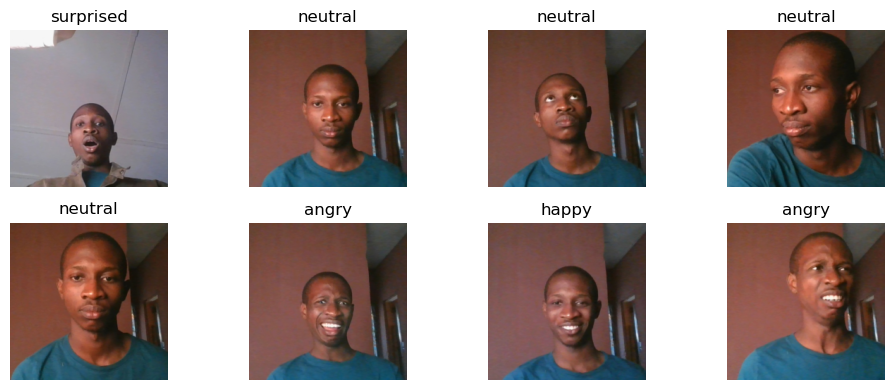

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(10, 4))

train_iter = iter(train_loader)
train_batch = next(train_iter)
train_images, train_labels = train_batch[0], train_batch[1]

for i in range(4):
    ex = train_images[i]
    lbl = train_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[0, i].imshow(im)
    ax[0, i].axis('off')
    ax[0, i].set_title(classes[lbl])

test_iter = iter(test_loader)
test_batch = next(test_iter)
test_images, test_labels = test_batch[0], test_batch[1]

for i in range(4):
    ex = test_images[i]
    lbl = test_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[1, i].imshow(im)
    ax[1, i].axis('off')
    ax[1, i].set_title(classes[lbl])

plt.tight_layout()
plt.show()


adding a normalizing transform to the transform Compose to maintain the right range of values

In [25]:
def get_mean_std(loader):
    count, batchsum, squaredbatchsum = 0, 0, 0
    for data, _ in tqdm(loader):
        batchsum += torch.mean(data, dim = [0, 2, 3])
        squaredbatchsum += torch.mean(data **2, dim =  [0, 2, 3])
        count += 1
    
    mean = batchsum / count
    std = (squaredbatchsum / count - mean**2) ** 0.5
    
    return mean, std
mean, std = get_mean_std(train_loader)
print(f"mean: {mean}")
print(f"std: {std}")

  0%|          | 0/15 [00:00<?, ?it/s]

mean: tensor([0.3953, 0.3041, 0.2902])
std: tensor([0.1744, 0.1109, 0.1307])


In [26]:
norm_transform = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize((220, 220)),
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

In [27]:
train_norm_dataset = datasets.ImageFolder(train_dir, transform = norm_transform)
test_norm_dataset = datasets.ImageFolder(test_dir, transform = norm_transform)

In [28]:
test_norm_loader = DataLoader(test_norm_dataset, batch_size = 10, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


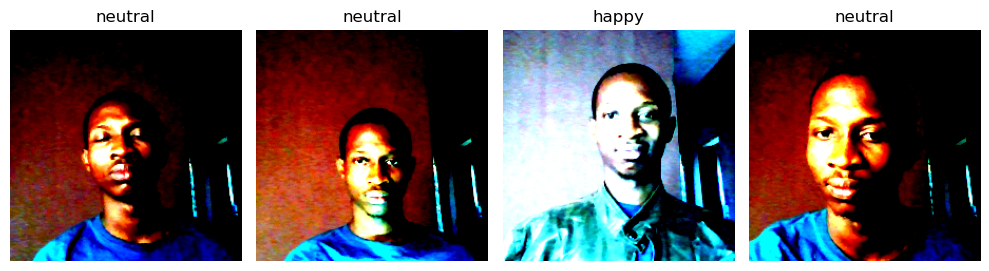

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(10, 4))

test_iter = iter(test_norm_loader)
test_batch = next(test_iter)
test_images, test_labels = test_batch[0], test_batch[1]

for i in range(4):
    ex = test_images[i]
    lbl = test_labels[i].item()
    im = ex.permute(1, 2, 0).numpy()

    ax[i].imshow(im)
    ax[i].axis('off')
    ax[i].set_title(classes[lbl])

plt.tight_layout()
plt.show()


splitting into training and validating data

In [30]:
train_dataset, val_dataset = random_split(train_norm_dataset, lengths = (0.8, 0.2))

checking the count of the classes represented in each of training and validating data

  0%|          | 0/116 [00:00<?, ?it/s]

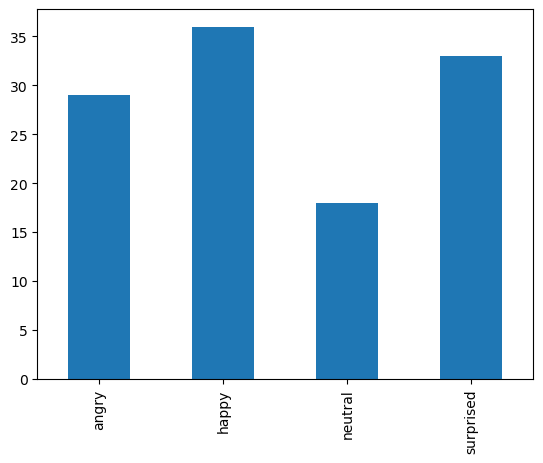

  0%|          | 0/28 [00:00<?, ?it/s]

<Axes: >

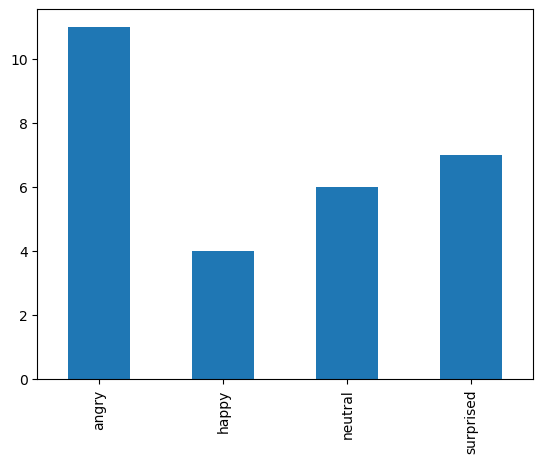

In [31]:
class_counts(train_dataset).plot(kind = 'bar')
plt.show()
class_counts(val_dataset).plot(kind = 'bar')

In [32]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [34]:
example = np.array(next(iter(val_loader))[0][0])  # First image of the first batch
example = np.transpose(example, (1, 2, 0))  # Channels-last for visualization

defining the model architecture

In [37]:
model = models.resnet18(pretrained=True)

num_classes = 4
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

c:\Users\USER\anaconda3\envs\pytorch_library\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\pytorch_library\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


setting the loss function and the optimizer

In [38]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

training the model

In [40]:
losses = []
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        optim.zero_grad()

        output = model(data)
        loss = loss_fn(output, labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

visualizing the training loss 

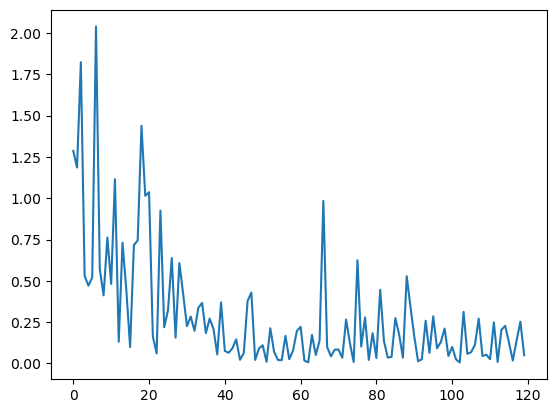

In [41]:
plt.plot(losses)

evaluating the model on the validation data

In [ ]:
def score(model, data_loader, loss_fn, device="cpu"):
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    average_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    return average_loss, accuracy

In [158]:
val_losses = []
val_accuracy = []
with torch.no_grad():
    count = 0
    for images, labels in tqdm(val_loader):
        output = model(images)
        count += 1
        loss = loss_fn(output, labels)
        val_losses.append(loss.item())
        print(count)

        correct = torch.eq(torch.argmax(softmax(output), dim = 1), labels)
        total_correct = torch.sum(correct).item()
        accuracy = total_correct / labels.shape[0]
        val_accuracy.append(accuracy)

  0%|          | 0/3 [00:00<?, ?it/s]

1


C:\Users\USER\AppData\Local\Temp\ipykernel_15408\2451991831.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.argmax(softmax(output), dim = 1), labels)


2
3


In [159]:
# plt.plot(val_losses)
print(val_losses)
print(val_accuracy)

[0.210798978805542, 0.060565732419490814, 1.2938497066497803]
[0.9, 1.0, 0.625]


8

In [162]:
next(iter(val_loader))[0].shape

torch.Size([10, 3, 220, 220])

In [140]:
out = output.detach().numpy()
lbl = labels.detach().numpy()
out, lbl

(array([[ 0.5693086 , -0.36757785, -3.1229506 ,  1.3455952 ],
        [-6.7795024 ,  6.975275  ,  0.50016314, -3.9497147 ],
        [-6.47891   ,  9.278394  , -0.02132868, -6.100299  ],
        [-1.7948492 , -2.5108647 , -5.054738  ,  7.780072  ],
        [ 2.6772575 , -0.33885983, -0.9852676 , -3.1554687 ],
        [ 0.32722983,  3.786227  , -0.3878039 , -5.776777  ],
        [ 0.5822632 ,  2.518781  , -1.2586209 , -3.830332  ],
        [ 0.85044163,  2.2612543 , -2.5364103 , -2.4310005 ]],
       dtype=float32),
 array([2, 1, 1, 3, 0, 0, 1, 0], dtype=int64))

In [141]:
correct

tensor([False, False, False, False, False, False, False, False])

In [46]:
train_loss, train_accuracy = score(model, train_loader, loss_fn)
validation_loss, validation_accuracy = score(model, val_loader, loss_fn)
print(f'training accuracy: {train_accuracy}\ntraining loss: {train_loss}')
print(f'validation accuracy: {validation_accuracy}\nvalidation loss: {validation_loss}')


Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

training accuracy: 1.0
training loss: 0.025714070785084163


In [121]:
for n in range(8):
    # plt.imshow(np.transpose(images[n], (1, 2, 0)))
    o = model(images[n].unsqueeze(0))
    cl = torch.argmax(torch.nn.functional.softmax(o[0])).item()
    print(f'{n}th prediction')
    print(f'predicted: {idx_to_class[cl]}')
    print(f'true label: {idx_to_class[labels[n].item()]}')

C:\Users\USER\AppData\Local\Temp\ipykernel_15408\2963818108.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cl = torch.argmax(torch.nn.functional.softmax(o[0])).item()


0th prediction
predicted: surprised
true label: neutral
1th prediction
predicted: happy
true label: happy
2th prediction
predicted: happy
true label: happy
3th prediction
predicted: surprised
true label: surprised
4th prediction
predicted: angry
true label: angry
5th prediction
predicted: happy
true label: angry
6th prediction
predicted: happy
true label: happy
7th prediction
predicted: happy
true label: angry


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


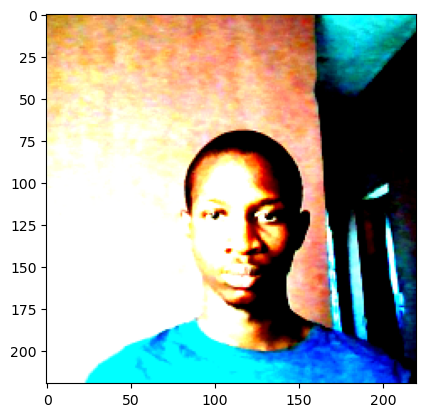

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


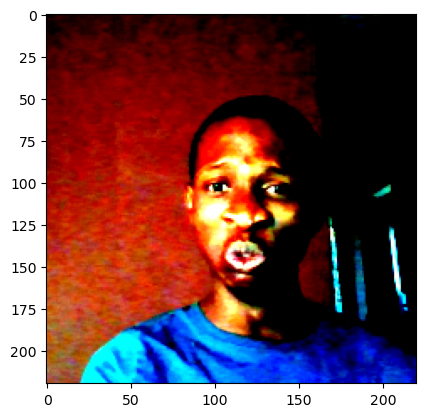

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


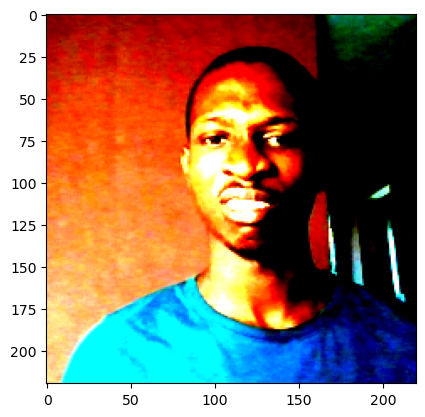

In [122]:
for n in [0, 5, 7]:
    plt.imshow(np.transpose(images[n], (1, 2, 0)))
    plt.show()